<a href="https://colab.research.google.com/github/yaiza612/scalable_classification_x_ray_data/blob/main/Annex_I_Xray_images_big_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This jupyter notebook shall serve as accompanying material to this repositories' README, a report for the “Big Data Engineering” subject at UPM’s Master in Computational Biology. It is thus only intended as a recopilation of used code; for the full discussion, please refer to the README.

**INITALIZATION OF SPARK AND IMPORTATION OF THE LIBRARIES**

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


In [ ]:
import sys

# Set current python version
python_version = f"3.7.10"

In [ ]:
# Install Miniconda
!wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

# Update Conda
!conda install --channel defaults conda python=$python_version --yes
!conda update --channel defaults --all --yes

# Append to the sys.path
_ = (sys.path
        .append(f"/usr/local/lib/python3.7/site-packages"))

os.environ['PYTHONHOME']="/usr/local"



--2022-02-10 21:40:56--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2022-02-10 21:40:56--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh.2’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M   234MB/s    in 0.2s    

2022-02-10 21:40:57 (234 MB/s) - ‘Miniconda3-4.5.4-Linux-x8

In [ ]:

# Install latest pre-release version of BigDL Orca 
# Installing BigDL Orca from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-orca


In [ ]:
# Install python dependencies
!pip install torch==1.7.1 torchvision==0.8.2
!pip install six cloudpickle
!pip install jep==3.9.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The aim of our code is classify chest ray images to provide a diagnosis of bacterial pneumonia o viral pneumonia. 
The interpretation of the X-ray images it is a bottleneck in the hospitals, and different classificators for these type of images are needed.
 

It is possible follow different approaches to reach our objective so we decide to look at the current state of the art for classification of x_ray images https://doi.org/10.1016/j.asoc.2020.106859. See more detail information in the README. 

**We would like to consider the tranfer learning to try out the model (InstaCovNet-19) but the code it is not available. 
But since the paper introduce the idea of improve the X-chest ray image classification by integration stacking of neural networks already known as good models, we will explore it by designing our own model in Spark with integrated stacking.**

In [ ]:
#!unzip /content/drive/MyDrive/Colab_Notebooks/archive.zip -d /content/drive/MyDrive/Colab_Notebooks/

The dataset can be found her: https://data.mendeley.com/datasets/rscbjbr9sj/2?__hstc=25856994.9a09a91357a104706292fa960434cfb0.1643116296328.1643116296328.1643116296328.1&__hssc=25856994.1.1643116296328&__hsfp=4215451866

It is used in this paper: https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5 to be classified by using ImageNet. 

The dataset is organized ito 3 folders: Train, test and validation.
It contains subfolders of each image category: Pneumonia and normal. 

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

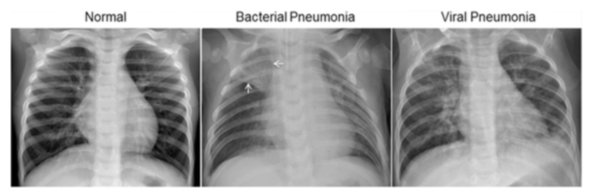

In [ ]:
# Define the path to the different folders:

test_path = '/content/drive/MyDrive/Colab_Notebooks/chest_xray/test'
train_path = '/content/drive/MyDrive/Colab_Notebooks/chest_xray/train'
validation_path = '/content/drive/MyDrive/Colab_Notebooks/chest_xray/val'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as T


We want to realize the following preprocessing: 

* CenterCrop - resizes the image to 224 x 224 
* RandomFlip - Randomly flips 50% of the image horizontally 
* ColorJitter- Randomly adjust the brigthness of 50% of the images
* Normalize - Normalize the images 


In [ ]:
def custom_transform(sample):
  transformer = torchvision.transforms.Compose([T.CenterCrop(size=(299, 299)), T.ToTensor(), T.RandomHorizontalFlip(p=0.5), 
                                  T.ColorJitter(brightness=0.5, hue=0), 
                                  T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
  return transformer(sample["image"]), sample["label"]

In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from os import listdir
from os.path import isfile, join
from PIL import Image
#from skimage import io

class CustomDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        normal_names = ["NORMAL/" + f for f in listdir(join(root_dir, "NORMAL")) if isfile(join(root_dir, "NORMAL", f))]
        labels_normal = [0]*len(normal_names)
        pneumonia_names = ["PNEUMONIA/" + f for f in listdir(join(root_dir, "PNEUMONIA")) if isfile(join(root_dir, "PNEUMONIA", f))]
        labels_pneumonia = [1]*len(pneumonia_names)
        self.labels = labels_normal
        self.labels.extend(labels_pneumonia)
        self.labels = np.asarray(self.labels, dtype=np.float32)
        # labelling done

        self.filenames = normal_names
        self.filenames.extend(pneumonia_names)

        

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.filenames[idx])
        image = Image.open(img_name).convert("RGB")
        #print(image.shape)
        label = torch.Tensor([self.labels[idx]])
        sample = {"image": image, "label": label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
train_data = CustomDataset(train_path, transform=custom_transform)
val_data = CustomDataset(validation_path, transform=custom_transform)
test_data = CustomDataset(test_path, transform=custom_transform)



In [ ]:
import torchvision
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
print('Number of images for training: ', len(train_data))
print('Number of images for testing: ', len(test_data))
print('Number of images for validation: ', len(val_data))

Number of images for training:  5216
Number of images for testing:  624
Number of images for validation:  16


## 5. NEURAL NETWORK ESTRUCTURE

### INTEGRATED STACKING NETWORK

In [ ]:
# import necesary libraries and modules
from __future__ import print_function
import os
import argparse

from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

In [ ]:
# recommended to set it to True when running BigDL in Jupyter notebook. 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":
    init_orca_context(cores=1, memory="8g") # run in local mode
elif cluster_mode == "k8s":
    init_orca_context(cluster_mode="k8s", num_nodes=2, cores=4) # run on K8s cluster
elif cluster_mode == "yarn":
    init_orca_context(
        cluster_mode="yarn-client", cores=4, num_nodes=2, memory="2g",
        driver_memory="10g", driver_cores=1,
        conf={"spark.rpc.message.maxSize": "1024",
              "spark.task.maxFailures": "1",
              "spark.driver.extraJavaOptions": "-Dbigdl.failure.retryTimes=1"}) # run on Hadoop YARN cluster

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/site-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/site-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/site-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
2022-02-10 21:42:16 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2022-02-10 21:42:20,290 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-02-10 21:42:20,294 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-02-10 21:42:20,295 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
2022-02-10 21:42:20,296 Thread-4 WARN The bufferSize is set to 4000 but bufferedIo is false: false
22-02-10 21:42:20 [Thread-4] INFO  Engine$:121 - Auto detect executor number and executor cores number
22-02-10 21:42:20 [Thread-4] INFO  Engine$:123 - Executor number is 1 and executor cores number is 1
22-02-10 21:42:21 [Thread-4] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 15
2022-02-10 21:42:21 WARN  SparkContext:66 - Using an existing SparkContext; some configuration may not take effect.
22-02-10 21:42:21 [Thread-4] INFO  Engine$:446 - Find existing spark context. Checking the spark conf...
cls.getname: com.intel.analytics.bigdl.dllib.utils.python.api.Sample
BigDLBasePickler registe


User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_HAND_THREAD=false
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_FORKJOIN_FRAMES=true
   KMP_FORKJOIN_FRAMES_MODE=3
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_ITT_PREPARE_DELAY=0
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_MWAIT_HINTS=0
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_

At the end the stacking of the 5 neural networks because a problem of the memory ram (12 gb in google collab free) and the resources of the paper are bigger than the one we have. 
It is just not possible define the same neural network they did because the session crush due to the limit of the ram, but we define the code and check that the network works anyways: 

```
# Define the network
class IntegratedNet(nn.Module):
  def __init__(self):
    super(IntegratedNet, self).__init__()

    self.resnet18 = models.resnet18(pretrained=True)
    self.resnet18.fc = nn.Linear(512, 32)

    self.densenet = models.densenet161(pretrained=True)
    self.densenet.classifier = nn.Linear(2208, 32)

    self.inception = models.inception_v3(pretrained=True)
    self.inception.fc = nn.Linear(2048, 32)
    
    self.mnasnet = models.mnasnet1_0(pretrained=True)
    self.mnasnet.classifier = nn.Sequential(nn.Dropout(0.2, inplace=True),
                                            nn.Linear(1280, 32))

    self.mobilenet_v2 = models.mobilenet_v2(pretrained=True)
    self.mobilenet_v2.classifier = nn.Sequential(nn.Dropout(0.2), nn.Linear(1280, 32))
    

    self.fc_out = nn.Linear(2*32, 1)  # for binary classification, use single output

  def forward(self, x):
    x_res = self.resnet18(x)
    x_dense = self.densenet(x.detach())
    x_inception = self.inception(x)[0]
    x_mnas = self.mnasnet(x)
    x_mobilenet = self.mobilenet_v2(x)
    
    #Concatenate the outputs
    x = torch.cat((x_res, x_dense, x_inception, x_mnas, x_mobilenet), axis=-1)
    x = self.fc_out(x)
    return x



```
But with the actual resources we cannot use it, we define therefore another 
neural network stacking two models instead. Which is what google collab can handle. 

In [ ]:
# check that stacking works as expected
a = torch.rand(size=(8, 32))
b = torch.rand(size=(8, 32))
c = torch.rand(size=(8, 32))
print(a.shape)
d = torch.cat((a, b, c), axis=-1)
print(d.shape)

torch.Size([8, 32])
torch.Size([8, 96])


The stacking works well and as we can see it is possible concatenate the models if we have the same shape. That means that it is needed to look at the network at every last layer to be able to stack all of them well. 
And we can be still improve our network using best practices for transfer learning. (https://arxiv.org/pdf/1911.02685.pdf)

In [ ]:
# Define the network
class IntegratedNet(nn.Module):
  def __init__(self):
    super(IntegratedNet, self).__init__()

    self.resnet18 = models.resnet18(pretrained=True)
    for param in self.resnet18.parameters():
      param.requires_grad = False
    self.resnet18.avgpool = nn.Sequential(nn.ReLU(),
                          nn.MaxPool2d(2, 2),
                          nn.Conv2d(in_channels=512, out_channels=64, kernel_size=3, stride=1, padding=1),
                          nn.BatchNorm2d(num_features=64),
                          nn.ReLU(),
                          nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
                          nn.BatchNorm2d(num_features=32),
                          nn.ReLU(),
                          nn.AdaptiveAvgPool2d(output_size=1))
    self.resnet18.fc = nn.Identity()
    # This code will help us to mantain the weights and extract the features according to the papers research to improve the 
    # performance of the transfering leaning (https://arxiv.org/pdf/1911.02685.pdf)
    self.mnasnet = models.mnasnet1_0(pretrained=True)
    for param in self.mnasnet.parameters():
      param.requires_grad = False
    self.mnasnet.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True),
                                      nn.ReLU(),
                                      nn.Linear(in_features=1280, out_features=256),
                                      nn.Dropout(p=0.2, inplace=True),
                                      nn.ReLU(),
                                      nn.Linear(256, 32))
    

    self.fc_out = nn.Sequential(nn.Linear(2*32, 1), nn.Sigmoid()) # for binary classification, use single output
    # will return values between 0 and 1 

  def forward(self, x):
    x_res = self.resnet18(x)
    x_mnas = self.mnasnet(x)
    x = torch.cat((x_res, x_mnas), axis=-1)
    x = self.fc_out(x)
    return x

In [ ]:
net = IntegratedNet()
optimizer = optim.Adam(net.parameters(), lr=0.0001)


In [ ]:
# training loss vs. epochs
criterion = nn.BCELoss() # binary cross entropy 
batch_size = 32
epochs = 2

In [ ]:
from bigdl.orca.learn.pytorch import Estimator 
from bigdl.orca.learn.metrics import BinaryAccuracy  # because we will have an output between 0 and 1. 

est = Estimator.from_torch(model=net, optimizer=optimizer, loss=criterion, metrics=[BinaryAccuracy()])

creating: createTorchLoss
creating: createTorchOptim
creating: createZooKerasBinaryAccuracy
creating: createEstimator


In [ ]:
from bigdl.orca.learn.trigger import EveryEpoch 

est.fit(data=train_loader, epochs=2, validation_data=test_loader,
        checkpoint_trigger=EveryEpoch())

creating: createEveryEpoch
creating: createMaxEpoch


22-02-10 21:42:56 [Thread-4] INFO  InternalDistriOptimizer$:944 - TorchModel[f33d891a] isTorch is true
22-02-10 21:42:56 [Thread-4] INFO  InternalDistriOptimizer$:950 - torch model will use 1 OMP threads.
22-02-10 21:42:56 [Thread-4] INFO  DistriOptimizer$:826 - caching training rdd ...


22-02-10 21:43:26 [Thread-4] INFO  DistriOptimizer$:652 - Cache thread models...
22-02-10 21:43:26 [Executor task launch worker for task 5] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 51
22-02-10 21:43:26 [Executor task launch worker for task 5] INFO  ThreadPool$:95 - Set mkl threads to 1 on thread 51
22-02-10 21:43:26 [Executor task launch worker for task 5] INFO  DistriOptimizer$:635 - model thread pool size is 1
2022-02-10 21:43:26 WARN  BlockManager:66 - Asked to remove block test_0weights0, which does not exist
2022-02-10 21:43:26 WARN  BlockManager:66 - Asked to remove block test_0gradients0, which does not exist
22-02-10 21:43:26 [Thread-4] INFO  DistriOptimizer$:654 - Cache thread models... done
22-02-10 21:43:26 [Thread-4] INFO  DistriOptimizer$:164 - Count dataset


22-02-10 21:44:35 [Thread-4] INFO  DistriOptimizer$:168 - Count dataset complete. Time elapsed: 68.657940791s


22-02-10 21:45:43 [Thread-4] WARN  DistriOptimizer$:170 - If the dataset is built directly from RDD[Minibatch], the data in each minibatch is fixed, and a single minibatch is randomly selected in each partition. If the dataset is transformed from RDD[Sample], each minibatch will be constructed on the fly from random samples, which is better for convergence.
22-02-10 21:45:43 [Thread-4] INFO  DistriOptimizer$:176 - config  {
	computeThresholdbatchSize: 100
	maxDropPercentage: 0.0
	warmupIterationNum: 200
	isLayerwiseScaled: false
	dropPercentage: 0.0
 }
22-02-10 21:45:43 [Thread-4] INFO  DistriOptimizer$:180 - Shuffle data
22-02-10 21:45:43 [Thread-4] INFO  DistriOptimizer$:183 - Shuffle data complete. Takes 1.2321E-4s


22-02-10 21:46:07 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 32/5216][Iteration 1][Wall Clock 18.958772659s] Trained 32.0 records in 18.958772659 seconds. Throughput is 1.687873 records/second. Loss is 0.7409593. 


22-02-10 21:46:14 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 64/5216][Iteration 2][Wall Clock 25.856106064s] Trained 32.0 records in 6.897333405 seconds. Throughput is 4.639474 records/second. Loss is 0.6954171. 


22-02-10 21:46:21 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 96/5216][Iteration 3][Wall Clock 32.647618171s] Trained 32.0 records in 6.791512107 seconds. Throughput is 4.711764 records/second. Loss is 0.67712724. 


22-02-10 21:46:28 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 128/5216][Iteration 4][Wall Clock 39.440653429s] Trained 32.0 records in 6.793035258 seconds. Throughput is 4.710707 records/second. Loss is 0.631244. 


22-02-10 21:46:35 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 160/5216][Iteration 5][Wall Clock 46.321818466s] Trained 32.0 records in 6.881165037 seconds. Throughput is 4.6503754 records/second. Loss is 0.5949562. 


22-02-10 21:46:42 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 192/5216][Iteration 6][Wall Clock 53.122212812s] Trained 32.0 records in 6.800394346 seconds. Throughput is 4.7056093 records/second. Loss is 0.5836719. 


22-02-10 21:46:48 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 224/5216][Iteration 7][Wall Clock 59.933256448s] Trained 32.0 records in 6.811043636 seconds. Throughput is 4.698252 records/second. Loss is 0.5472795. 


22-02-10 21:46:55 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 256/5216][Iteration 8][Wall Clock 66.715599266s] Trained 32.0 records in 6.782342818 seconds. Throughput is 4.7181334 records/second. Loss is 0.5152236. 


22-02-10 21:47:02 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 288/5216][Iteration 9][Wall Clock 73.506168474s] Trained 32.0 records in 6.790569208 seconds. Throughput is 4.712418 records/second. Loss is 0.5098698. 


22-02-10 21:47:09 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 320/5216][Iteration 10][Wall Clock 80.263415276s] Trained 32.0 records in 6.757246802 seconds. Throughput is 4.7356563 records/second. Loss is 0.47625983. 


22-02-10 21:47:15 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 352/5216][Iteration 11][Wall Clock 87.033361606s] Trained 32.0 records in 6.76994633 seconds. Throughput is 4.7267733 records/second. Loss is 0.49023643. 


22-02-10 21:47:22 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 384/5216][Iteration 12][Wall Clock 93.7706748s] Trained 32.0 records in 6.737313194 seconds. Throughput is 4.7496676 records/second. Loss is 0.44272727. 


22-02-10 21:47:29 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 416/5216][Iteration 13][Wall Clock 101.058661889s] Trained 32.0 records in 7.287987089 seconds. Throughput is 4.390787 records/second. Loss is 0.41462737. 


22-02-10 21:47:40 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 448/5216][Iteration 14][Wall Clock 111.393746668s] Trained 32.0 records in 10.335084779 seconds. Throughput is 3.0962493 records/second. Loss is 0.39545882. 


22-02-10 21:47:47 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 480/5216][Iteration 15][Wall Clock 118.859456396s] Trained 32.0 records in 7.465709728 seconds. Throughput is 4.2862635 records/second. Loss is 0.41585344. 


22-02-10 21:47:54 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 512/5216][Iteration 16][Wall Clock 125.658540022s] Trained 32.0 records in 6.799083626 seconds. Throughput is 4.7065167 records/second. Loss is 0.37532234. 


22-02-10 21:48:01 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 544/5216][Iteration 17][Wall Clock 132.404444545s] Trained 32.0 records in 6.745904523 seconds. Throughput is 4.743619 records/second. Loss is 0.349044. 


22-02-10 21:48:08 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 576/5216][Iteration 18][Wall Clock 139.22069048s] Trained 32.0 records in 6.816245935 seconds. Throughput is 4.6946664 records/second. Loss is 0.35089. 


22-02-10 21:48:14 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 608/5216][Iteration 19][Wall Clock 146.018535506s] Trained 32.0 records in 6.797845026 seconds. Throughput is 4.707374 records/second. Loss is 0.38825566. 


22-02-10 21:48:21 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 640/5216][Iteration 20][Wall Clock 152.783803897s] Trained 32.0 records in 6.765268391 seconds. Throughput is 4.7300415 records/second. Loss is 0.32899144. 


22-02-10 21:48:28 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 672/5216][Iteration 21][Wall Clock 159.622185819s] Trained 32.0 records in 6.838381922 seconds. Throughput is 4.6794696 records/second. Loss is 0.3136489. 


22-02-10 21:48:35 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 704/5216][Iteration 22][Wall Clock 166.446241182s] Trained 32.0 records in 6.824055363 seconds. Throughput is 4.689294 records/second. Loss is 0.31508517. 


22-02-10 21:48:42 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 736/5216][Iteration 23][Wall Clock 173.222055251s] Trained 32.0 records in 6.775814069 seconds. Throughput is 4.7226796 records/second. Loss is 0.33683923. 


22-02-10 21:48:48 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 768/5216][Iteration 24][Wall Clock 179.9197875s] Trained 32.0 records in 6.697732249 seconds. Throughput is 4.777736 records/second. Loss is 0.28181. 


22-02-10 21:48:55 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 800/5216][Iteration 25][Wall Clock 186.727560375s] Trained 32.0 records in 6.807772875 seconds. Throughput is 4.700509 records/second. Loss is 0.3039229. 


22-02-10 21:49:02 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 832/5216][Iteration 26][Wall Clock 193.522956942s] Trained 32.0 records in 6.795396567 seconds. Throughput is 4.70907 records/second. Loss is 0.33218768. 


22-02-10 21:49:09 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 864/5216][Iteration 27][Wall Clock 200.3053435s] Trained 32.0 records in 6.782386558 seconds. Throughput is 4.718103 records/second. Loss is 0.25397834. 


22-02-10 21:49:15 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 896/5216][Iteration 28][Wall Clock 207.017343117s] Trained 32.0 records in 6.711999617 seconds. Throughput is 4.767581 records/second. Loss is 0.24323863. 


22-02-10 21:49:22 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 928/5216][Iteration 29][Wall Clock 213.807601555s] Trained 32.0 records in 6.790258438 seconds. Throughput is 4.7126336 records/second. Loss is 0.20609272. 


22-02-10 21:49:29 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 960/5216][Iteration 30][Wall Clock 220.638302568s] Trained 32.0 records in 6.830701013 seconds. Throughput is 4.6847315 records/second. Loss is 0.30081338. 


22-02-10 21:49:36 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 992/5216][Iteration 31][Wall Clock 227.505102886s] Trained 32.0 records in 6.866800318 seconds. Throughput is 4.6601033 records/second. Loss is 0.36461398. 


22-02-10 21:49:43 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1024/5216][Iteration 32][Wall Clock 234.315430881s] Trained 32.0 records in 6.810327995 seconds. Throughput is 4.6987457 records/second. Loss is 0.59439397. 


22-02-10 21:49:50 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1056/5216][Iteration 33][Wall Clock 241.129526766s] Trained 32.0 records in 6.814095885 seconds. Throughput is 4.6961474 records/second. Loss is 0.35055575. 


22-02-10 21:49:56 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1088/5216][Iteration 34][Wall Clock 247.834827934s] Trained 32.0 records in 6.705301168 seconds. Throughput is 4.772343 records/second. Loss is 0.25412917. 


22-02-10 21:50:03 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1120/5216][Iteration 35][Wall Clock 254.625150112s] Trained 32.0 records in 6.790322178 seconds. Throughput is 4.7125893 records/second. Loss is 0.1865121. 


22-02-10 21:50:10 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1152/5216][Iteration 36][Wall Clock 261.364822455s] Trained 32.0 records in 6.739672343 seconds. Throughput is 4.7480054 records/second. Loss is 0.31071025. 


22-02-10 21:50:17 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1184/5216][Iteration 37][Wall Clock 268.101945448s] Trained 32.0 records in 6.737122993 seconds. Throughput is 4.749802 records/second. Loss is 0.2971943. 


22-02-10 21:50:23 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1216/5216][Iteration 38][Wall Clock 274.868748738s] Trained 32.0 records in 6.76680329 seconds. Throughput is 4.7289686 records/second. Loss is 0.1827384. 


22-02-10 21:50:30 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1248/5216][Iteration 39][Wall Clock 281.6256142s] Trained 32.0 records in 6.756865462 seconds. Throughput is 4.735924 records/second. Loss is 0.1761009. 


22-02-10 21:50:37 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1280/5216][Iteration 40][Wall Clock 288.39495119s] Trained 32.0 records in 6.76933699 seconds. Throughput is 4.7271986 records/second. Loss is 0.4032011. 


22-02-10 21:50:44 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1312/5216][Iteration 41][Wall Clock 295.183220978s] Trained 32.0 records in 6.788269788 seconds. Throughput is 4.714014 records/second. Loss is 0.27252793. 


22-02-10 21:50:50 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1344/5216][Iteration 42][Wall Clock 301.921077822s] Trained 32.0 records in 6.737856844 seconds. Throughput is 4.7492847 records/second. Loss is 0.31315118. 


22-02-10 21:50:57 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1376/5216][Iteration 43][Wall Clock 308.770502863s] Trained 32.0 records in 6.849425041 seconds. Throughput is 4.671925 records/second. Loss is 0.26336163. 


22-02-10 21:51:04 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1408/5216][Iteration 44][Wall Clock 315.538317493s] Trained 32.0 records in 6.76781463 seconds. Throughput is 4.728262 records/second. Loss is 0.17597584. 


22-02-10 21:51:11 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1440/5216][Iteration 45][Wall Clock 322.298508645s] Trained 32.0 records in 6.760191152 seconds. Throughput is 4.733594 records/second. Loss is 0.2258178. 


22-02-10 21:51:18 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1472/5216][Iteration 46][Wall Clock 329.084691931s] Trained 32.0 records in 6.786183286 seconds. Throughput is 4.7154636 records/second. Loss is 0.22913301. 


22-02-10 21:51:24 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1504/5216][Iteration 47][Wall Clock 335.819242218s] Trained 32.0 records in 6.734550287 seconds. Throughput is 4.7516165 records/second. Loss is 0.22196561. 


22-02-10 21:51:31 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1536/5216][Iteration 48][Wall Clock 342.628164485s] Trained 32.0 records in 6.808922267 seconds. Throughput is 4.6997156 records/second. Loss is 0.2210895. 


22-02-10 21:51:38 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1568/5216][Iteration 49][Wall Clock 349.484031166s] Trained 32.0 records in 6.855866681 seconds. Throughput is 4.6675353 records/second. Loss is 0.33125776. 


22-02-10 21:51:45 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1600/5216][Iteration 50][Wall Clock 356.317319069s] Trained 32.0 records in 6.833287903 seconds. Throughput is 4.682958 records/second. Loss is 0.36880094. 


22-02-10 21:51:52 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1632/5216][Iteration 51][Wall Clock 363.094483681s] Trained 32.0 records in 6.777164612 seconds. Throughput is 4.721739 records/second. Loss is 0.27387702. 


22-02-10 21:51:58 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1664/5216][Iteration 52][Wall Clock 369.813809611s] Trained 32.0 records in 6.71932593 seconds. Throughput is 4.7623825 records/second. Loss is 0.1542029. 


22-02-10 21:52:05 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1696/5216][Iteration 53][Wall Clock 376.619378499s] Trained 32.0 records in 6.805568888 seconds. Throughput is 4.7020316 records/second. Loss is 0.17516123. 


22-02-10 21:52:12 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1728/5216][Iteration 54][Wall Clock 383.337157787s] Trained 32.0 records in 6.717779288 seconds. Throughput is 4.763479 records/second. Loss is 0.16206574. 


22-02-10 21:52:19 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1760/5216][Iteration 55][Wall Clock 390.075957474s] Trained 32.0 records in 6.738799687 seconds. Throughput is 4.74862 records/second. Loss is 0.24132498. 


22-02-10 21:52:25 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1792/5216][Iteration 56][Wall Clock 396.749384099s] Trained 32.0 records in 6.673426625 seconds. Throughput is 4.795138 records/second. Loss is 0.1807705. 


22-02-10 21:52:32 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1824/5216][Iteration 57][Wall Clock 403.570949314s] Trained 32.0 records in 6.821565215 seconds. Throughput is 4.6910057 records/second. Loss is 0.21054552. 


22-02-10 21:52:39 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1856/5216][Iteration 58][Wall Clock 410.351934625s] Trained 32.0 records in 6.780985311 seconds. Throughput is 4.719078 records/second. Loss is 0.22094488. 


22-02-10 21:52:46 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1888/5216][Iteration 59][Wall Clock 417.134873645s] Trained 32.0 records in 6.78293902 seconds. Throughput is 4.717719 records/second. Loss is 0.29512477. 


22-02-10 21:52:52 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1920/5216][Iteration 60][Wall Clock 423.784983823s] Trained 32.0 records in 6.650110178 seconds. Throughput is 4.81195 records/second. Loss is 0.18638173. 


22-02-10 21:52:59 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1952/5216][Iteration 61][Wall Clock 430.535333277s] Trained 32.0 records in 6.750349454 seconds. Throughput is 4.740495 records/second. Loss is 0.13764668. 


22-02-10 21:53:06 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 1984/5216][Iteration 62][Wall Clock 437.319049228s] Trained 32.0 records in 6.783715951 seconds. Throughput is 4.717179 records/second. Loss is 0.22197035. 


22-02-10 21:53:13 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2016/5216][Iteration 63][Wall Clock 444.135539783s] Trained 32.0 records in 6.816490555 seconds. Throughput is 4.6944976 records/second. Loss is 0.14469346. 


22-02-10 21:53:19 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2048/5216][Iteration 64][Wall Clock 450.968796607s] Trained 32.0 records in 6.833256824 seconds. Throughput is 4.682979 records/second. Loss is 0.187809. 


22-02-10 21:53:26 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2080/5216][Iteration 65][Wall Clock 457.73510084s] Trained 32.0 records in 6.766304233 seconds. Throughput is 4.7293177 records/second. Loss is 0.14461237. 


22-02-10 21:53:33 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2112/5216][Iteration 66][Wall Clock 464.505803692s] Trained 32.0 records in 6.770702852 seconds. Throughput is 4.726245 records/second. Loss is 0.16437449. 


22-02-10 21:53:40 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2144/5216][Iteration 67][Wall Clock 471.370337762s] Trained 32.0 records in 6.86453407 seconds. Throughput is 4.661642 records/second. Loss is 0.33725885. 


22-02-10 21:53:47 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2176/5216][Iteration 68][Wall Clock 478.165744871s] Trained 32.0 records in 6.795407109 seconds. Throughput is 4.709063 records/second. Loss is 0.26953664. 


22-02-10 21:53:54 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2208/5216][Iteration 69][Wall Clock 485.002154595s] Trained 32.0 records in 6.836409724 seconds. Throughput is 4.6808195 records/second. Loss is 0.21637137. 


22-02-10 21:54:00 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2240/5216][Iteration 70][Wall Clock 491.817387401s] Trained 32.0 records in 6.815232806 seconds. Throughput is 4.695364 records/second. Loss is 0.19883518. 


22-02-10 21:54:07 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2272/5216][Iteration 71][Wall Clock 498.581032464s] Trained 32.0 records in 6.763645063 seconds. Throughput is 4.731177 records/second. Loss is 0.13596493. 


22-02-10 21:54:14 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2304/5216][Iteration 72][Wall Clock 505.354967625s] Trained 32.0 records in 6.773935161 seconds. Throughput is 4.7239895 records/second. Loss is 0.13678177. 


22-02-10 21:54:21 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2336/5216][Iteration 73][Wall Clock 512.138171545s] Trained 32.0 records in 6.78320392 seconds. Throughput is 4.7175345 records/second. Loss is 0.2678615. 


22-02-10 21:54:27 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2368/5216][Iteration 74][Wall Clock 518.88708231s] Trained 32.0 records in 6.748910765 seconds. Throughput is 4.7415056 records/second. Loss is 0.19904917. 


22-02-10 21:54:34 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2400/5216][Iteration 75][Wall Clock 525.661121382s] Trained 32.0 records in 6.774039072 seconds. Throughput is 4.723917 records/second. Loss is 0.2796418. 


22-02-10 21:54:41 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2432/5216][Iteration 76][Wall Clock 532.341938596s] Trained 32.0 records in 6.680817214 seconds. Throughput is 4.789833 records/second. Loss is 0.14647543. 


22-02-10 21:54:48 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2464/5216][Iteration 77][Wall Clock 539.16928228s] Trained 32.0 records in 6.827343684 seconds. Throughput is 4.6870356 records/second. Loss is 0.32743. 


22-02-10 21:54:54 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2496/5216][Iteration 78][Wall Clock 545.914887856s] Trained 32.0 records in 6.745605576 seconds. Throughput is 4.7438293 records/second. Loss is 0.18688497. 


22-02-10 21:55:01 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2528/5216][Iteration 79][Wall Clock 552.647337904s] Trained 32.0 records in 6.732450048 seconds. Throughput is 4.753099 records/second. Loss is 0.23845446. 


22-02-10 21:55:08 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2560/5216][Iteration 80][Wall Clock 559.371336613s] Trained 32.0 records in 6.723998709 seconds. Throughput is 4.759073 records/second. Loss is 0.16988738. 


22-02-10 21:55:15 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2592/5216][Iteration 81][Wall Clock 566.131565306s] Trained 32.0 records in 6.760228693 seconds. Throughput is 4.7335677 records/second. Loss is 0.13906235. 


22-02-10 21:55:21 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2624/5216][Iteration 82][Wall Clock 572.843014815s] Trained 32.0 records in 6.711449509 seconds. Throughput is 4.7679715 records/second. Loss is 0.21579969. 


22-02-10 21:55:28 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2656/5216][Iteration 83][Wall Clock 579.533760008s] Trained 32.0 records in 6.690745193 seconds. Throughput is 4.782726 records/second. Loss is 0.15427372. 


22-02-10 21:55:35 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2688/5216][Iteration 84][Wall Clock 586.372081151s] Trained 32.0 records in 6.838321143 seconds. Throughput is 4.679511 records/second. Loss is 0.14539114. 


22-02-10 21:55:42 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2720/5216][Iteration 85][Wall Clock 593.096883119s] Trained 32.0 records in 6.724801968 seconds. Throughput is 4.7585044 records/second. Loss is 0.15692309. 


22-02-10 21:55:48 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2752/5216][Iteration 86][Wall Clock 599.79599855s] Trained 32.0 records in 6.699115431 seconds. Throughput is 4.77675 records/second. Loss is 0.15897769. 


22-02-10 21:55:55 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2784/5216][Iteration 87][Wall Clock 606.502156831s] Trained 32.0 records in 6.706158281 seconds. Throughput is 4.7717338 records/second. Loss is 0.13225605. 


22-02-10 21:56:02 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2816/5216][Iteration 88][Wall Clock 613.30298778s] Trained 32.0 records in 6.800830949 seconds. Throughput is 4.7053075 records/second. Loss is 0.17590977. 


22-02-10 21:56:09 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2848/5216][Iteration 89][Wall Clock 620.063338714s] Trained 32.0 records in 6.760350934 seconds. Throughput is 4.7334824 records/second. Loss is 0.18737496. 


22-02-10 21:56:15 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2880/5216][Iteration 90][Wall Clock 626.859529402s] Trained 32.0 records in 6.796190688 seconds. Throughput is 4.70852 records/second. Loss is 0.2648821. 


22-02-10 21:56:22 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2912/5216][Iteration 91][Wall Clock 633.611201937s] Trained 32.0 records in 6.751672535 seconds. Throughput is 4.7395663 records/second. Loss is 0.11329633. 


22-02-10 21:56:29 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2944/5216][Iteration 92][Wall Clock 640.301207569s] Trained 32.0 records in 6.690005632 seconds. Throughput is 4.7832546 records/second. Loss is 0.15274645. 


22-02-10 21:56:36 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 2976/5216][Iteration 93][Wall Clock 647.115259835s] Trained 32.0 records in 6.814052266 seconds. Throughput is 4.696178 records/second. Loss is 0.25433618. 


22-02-10 21:56:42 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3008/5216][Iteration 94][Wall Clock 653.898993906s] Trained 32.0 records in 6.783734071 seconds. Throughput is 4.7171664 records/second. Loss is 0.15290111. 


22-02-10 21:56:49 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3040/5216][Iteration 95][Wall Clock 660.724480991s] Trained 32.0 records in 6.825487085 seconds. Throughput is 4.68831 records/second. Loss is 0.2581003. 


22-02-10 21:56:56 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3072/5216][Iteration 96][Wall Clock 667.430151362s] Trained 32.0 records in 6.705670371 seconds. Throughput is 4.772081 records/second. Loss is 0.15010372. 


22-02-10 21:57:03 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3104/5216][Iteration 97][Wall Clock 674.235728649s] Trained 32.0 records in 6.805577287 seconds. Throughput is 4.702026 records/second. Loss is 0.13532987. 


22-02-10 21:57:09 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3136/5216][Iteration 98][Wall Clock 680.949401619s] Trained 32.0 records in 6.71367297 seconds. Throughput is 4.766392 records/second. Loss is 0.11280563. 


22-02-10 21:57:16 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3168/5216][Iteration 99][Wall Clock 687.781583763s] Trained 32.0 records in 6.832182144 seconds. Throughput is 4.683716 records/second. Loss is 0.1720517. 


22-02-10 21:57:23 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3200/5216][Iteration 100][Wall Clock 694.571733863s] Trained 32.0 records in 6.7901501 seconds. Throughput is 4.712709 records/second. Loss is 0.106909506. 


22-02-10 21:57:30 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3232/5216][Iteration 101][Wall Clock 701.360011623s] Trained 32.0 records in 6.78827776 seconds. Throughput is 4.714009 records/second. Loss is 0.09179832. 


22-02-10 21:57:37 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3264/5216][Iteration 102][Wall Clock 708.220740323s] Trained 32.0 records in 6.8607287 seconds. Throughput is 4.6642275 records/second. Loss is 0.22691554. 


22-02-10 21:57:44 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3296/5216][Iteration 103][Wall Clock 714.996709434s] Trained 32.0 records in 6.775969111 seconds. Throughput is 4.722572 records/second. Loss is 0.14895684. 


22-02-10 21:57:50 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3328/5216][Iteration 104][Wall Clock 721.731046821s] Trained 32.0 records in 6.734337387 seconds. Throughput is 4.7517667 records/second. Loss is 0.19885175. 


22-02-10 21:57:57 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3360/5216][Iteration 105][Wall Clock 728.510744022s] Trained 32.0 records in 6.779697201 seconds. Throughput is 4.7199745 records/second. Loss is 0.19454193. 


22-02-10 21:58:04 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3392/5216][Iteration 106][Wall Clock 735.372224752s] Trained 32.0 records in 6.86148073 seconds. Throughput is 4.6637163 records/second. Loss is 0.12056172. 


22-02-10 21:58:11 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3424/5216][Iteration 107][Wall Clock 742.131011516s] Trained 32.0 records in 6.758786764 seconds. Throughput is 4.7345777 records/second. Loss is 0.137075. 


22-02-10 21:58:17 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3456/5216][Iteration 108][Wall Clock 748.80626275s] Trained 32.0 records in 6.675251234 seconds. Throughput is 4.793827 records/second. Loss is 0.107153356. 


22-02-10 21:58:24 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3488/5216][Iteration 109][Wall Clock 755.668238141s] Trained 32.0 records in 6.861975391 seconds. Throughput is 4.66338 records/second. Loss is 0.19318223. 


22-02-10 21:58:31 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3520/5216][Iteration 110][Wall Clock 762.429594185s] Trained 32.0 records in 6.761356044 seconds. Throughput is 4.7327785 records/second. Loss is 0.15277529. 


22-02-10 21:58:38 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3552/5216][Iteration 111][Wall Clock 769.212623245s] Trained 32.0 records in 6.78302906 seconds. Throughput is 4.717656 records/second. Loss is 0.09626183. 


22-02-10 21:58:45 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3584/5216][Iteration 112][Wall Clock 776.014308834s] Trained 32.0 records in 6.801685589 seconds. Throughput is 4.704716 records/second. Loss is 0.10834856. 


22-02-10 21:58:51 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3616/5216][Iteration 113][Wall Clock 782.710978996s] Trained 32.0 records in 6.696670162 seconds. Throughput is 4.7784944 records/second. Loss is 0.1213431. 


22-02-10 21:58:58 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3648/5216][Iteration 114][Wall Clock 789.491921627s] Trained 32.0 records in 6.780942631 seconds. Throughput is 4.719108 records/second. Loss is 0.11271076. 


22-02-10 21:59:05 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3680/5216][Iteration 115][Wall Clock 796.222577094s] Trained 32.0 records in 6.730655467 seconds. Throughput is 4.754366 records/second. Loss is 0.24562243. 


22-02-10 21:59:12 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3712/5216][Iteration 116][Wall Clock 803.013196193s] Trained 32.0 records in 6.790619099 seconds. Throughput is 4.7123833 records/second. Loss is 0.17568555. 


22-02-10 21:59:18 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3744/5216][Iteration 117][Wall Clock 809.821113871s] Trained 32.0 records in 6.807917678 seconds. Throughput is 4.7004094 records/second. Loss is 0.14830168. 


22-02-10 21:59:25 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3776/5216][Iteration 118][Wall Clock 816.53414131s] Trained 32.0 records in 6.713027439 seconds. Throughput is 4.766851 records/second. Loss is 0.121589705. 


22-02-10 21:59:32 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3808/5216][Iteration 119][Wall Clock 823.276304715s] Trained 32.0 records in 6.742163405 seconds. Throughput is 4.746251 records/second. Loss is 0.15787977. 


22-02-10 21:59:39 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3840/5216][Iteration 120][Wall Clock 830.116225628s] Trained 32.0 records in 6.839920913 seconds. Throughput is 4.6784167 records/second. Loss is 0.10928552. 


22-02-10 21:59:45 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3872/5216][Iteration 121][Wall Clock 836.916152179s] Trained 32.0 records in 6.799926551 seconds. Throughput is 4.705933 records/second. Loss is 0.085648045. 


22-02-10 21:59:52 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3904/5216][Iteration 122][Wall Clock 843.693556481s] Trained 32.0 records in 6.777404302 seconds. Throughput is 4.7215714 records/second. Loss is 0.21453269. 


22-02-10 21:59:59 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3936/5216][Iteration 123][Wall Clock 850.444829906s] Trained 32.0 records in 6.751273425 seconds. Throughput is 4.739846 records/second. Loss is 0.0913267. 


22-02-10 22:00:06 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 3968/5216][Iteration 124][Wall Clock 857.187161634s] Trained 32.0 records in 6.742331728 seconds. Throughput is 4.746133 records/second. Loss is 0.07844189. 


22-02-10 22:00:13 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4000/5216][Iteration 125][Wall Clock 864.020873871s] Trained 32.0 records in 6.833712237 seconds. Throughput is 4.6826673 records/second. Loss is 0.086605534. 


22-02-10 22:00:19 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4032/5216][Iteration 126][Wall Clock 870.820868092s] Trained 32.0 records in 6.799994221 seconds. Throughput is 4.7058864 records/second. Loss is 0.079634. 


22-02-10 22:00:26 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4064/5216][Iteration 127][Wall Clock 877.581527845s] Trained 32.0 records in 6.760659753 seconds. Throughput is 4.733266 records/second. Loss is 0.06550676. 


22-02-10 22:00:33 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4096/5216][Iteration 128][Wall Clock 884.401044821s] Trained 32.0 records in 6.819516976 seconds. Throughput is 4.6924143 records/second. Loss is 0.09587483. 


22-02-10 22:00:40 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4128/5216][Iteration 129][Wall Clock 891.209141618s] Trained 32.0 records in 6.808096797 seconds. Throughput is 4.7002854 records/second. Loss is 0.08211537. 


22-02-10 22:00:47 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4160/5216][Iteration 130][Wall Clock 898.062641029s] Trained 32.0 records in 6.853499411 seconds. Throughput is 4.6691475 records/second. Loss is 0.089452386. 


22-02-10 22:00:53 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4192/5216][Iteration 131][Wall Clock 904.776157688s] Trained 32.0 records in 6.713516659 seconds. Throughput is 4.7665033 records/second. Loss is 0.06624305. 


22-02-10 22:01:00 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4224/5216][Iteration 132][Wall Clock 911.565186978s] Trained 32.0 records in 6.78902929 seconds. Throughput is 4.713487 records/second. Loss is 0.0826805. 


22-02-10 22:01:07 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4256/5216][Iteration 133][Wall Clock 918.314392512s] Trained 32.0 records in 6.749205534 seconds. Throughput is 4.7412987 records/second. Loss is 0.14187321. 


22-02-10 22:01:14 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4288/5216][Iteration 134][Wall Clock 925.072321315s] Trained 32.0 records in 6.757928803 seconds. Throughput is 4.7351785 records/second. Loss is 0.06650776. 


22-02-10 22:01:20 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4320/5216][Iteration 135][Wall Clock 931.855824566s] Trained 32.0 records in 6.783503251 seconds. Throughput is 4.7173266 records/second. Loss is 0.15353185. 


22-02-10 22:01:27 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4352/5216][Iteration 136][Wall Clock 938.720085626s] Trained 32.0 records in 6.86426106 seconds. Throughput is 4.661827 records/second. Loss is 0.23408332. 


22-02-10 22:01:34 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4384/5216][Iteration 137][Wall Clock 945.664278366s] Trained 32.0 records in 6.94419274 seconds. Throughput is 4.6081667 records/second. Loss is 0.14926878. 


22-02-10 22:01:41 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4416/5216][Iteration 138][Wall Clock 952.449862686s] Trained 32.0 records in 6.78558432 seconds. Throughput is 4.71588 records/second. Loss is 0.10525458. 


22-02-10 22:01:48 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4448/5216][Iteration 139][Wall Clock 959.251484564s] Trained 32.0 records in 6.801621878 seconds. Throughput is 4.70476 records/second. Loss is 0.1341818. 


22-02-10 22:01:55 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4480/5216][Iteration 140][Wall Clock 966.020428086s] Trained 32.0 records in 6.768943522 seconds. Throughput is 4.7274733 records/second. Loss is 0.06436069. 


22-02-10 22:02:01 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4512/5216][Iteration 141][Wall Clock 972.786675079s] Trained 32.0 records in 6.766246993 seconds. Throughput is 4.7293577 records/second. Loss is 0.09290875. 


22-02-10 22:02:08 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4544/5216][Iteration 142][Wall Clock 979.535595624s] Trained 32.0 records in 6.748920545 seconds. Throughput is 4.741499 records/second. Loss is 0.13062987. 


22-02-10 22:02:15 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4576/5216][Iteration 143][Wall Clock 986.343917332s] Trained 32.0 records in 6.808321708 seconds. Throughput is 4.7001305 records/second. Loss is 0.15823394. 


22-02-10 22:02:22 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4608/5216][Iteration 144][Wall Clock 993.15293503s] Trained 32.0 records in 6.809017698 seconds. Throughput is 4.69965 records/second. Loss is 0.10641916. 


22-02-10 22:02:28 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4640/5216][Iteration 145][Wall Clock 999.918971653s] Trained 32.0 records in 6.766036623 seconds. Throughput is 4.7295046 records/second. Loss is 0.07621796. 


22-02-10 22:02:35 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4672/5216][Iteration 146][Wall Clock 1006.65198961s] Trained 32.0 records in 6.733017957 seconds. Throughput is 4.752698 records/second. Loss is 0.061431445. 


22-02-10 22:02:42 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4704/5216][Iteration 147][Wall Clock 1013.419359322s] Trained 32.0 records in 6.767369712 seconds. Throughput is 4.728573 records/second. Loss is 0.10362315. 


22-02-10 22:02:49 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4736/5216][Iteration 148][Wall Clock 1020.154452648s] Trained 32.0 records in 6.735093326 seconds. Throughput is 4.7512336 records/second. Loss is 0.11575904. 


22-02-10 22:02:56 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4768/5216][Iteration 149][Wall Clock 1026.927711169s] Trained 32.0 records in 6.773258521 seconds. Throughput is 4.7244616 records/second. Loss is 0.05681411. 


22-02-10 22:03:02 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4800/5216][Iteration 150][Wall Clock 1033.694225571s] Trained 32.0 records in 6.766514402 seconds. Throughput is 4.7291703 records/second. Loss is 0.060877793. 


22-02-10 22:03:09 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4832/5216][Iteration 151][Wall Clock 1040.516422206s] Trained 32.0 records in 6.822196635 seconds. Throughput is 4.6905713 records/second. Loss is 0.042783625. 


22-02-10 22:03:16 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4864/5216][Iteration 152][Wall Clock 1047.326092743s] Trained 32.0 records in 6.809670537 seconds. Throughput is 4.6991997 records/second. Loss is 0.08216939. 


22-02-10 22:03:23 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4896/5216][Iteration 153][Wall Clock 1054.120556031s] Trained 32.0 records in 6.794463288 seconds. Throughput is 4.7097173 records/second. Loss is 0.07741855. 


22-02-10 22:03:29 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4928/5216][Iteration 154][Wall Clock 1060.852311018s] Trained 32.0 records in 6.731754987 seconds. Throughput is 4.7535896 records/second. Loss is 0.2626429. 


22-02-10 22:03:36 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4960/5216][Iteration 155][Wall Clock 1067.612095532s] Trained 32.0 records in 6.759784514 seconds. Throughput is 4.7338786 records/second. Loss is 0.07869965. 


22-02-10 22:03:43 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 4992/5216][Iteration 156][Wall Clock 1074.320605472s] Trained 32.0 records in 6.70850994 seconds. Throughput is 4.7700605 records/second. Loss is 0.093527876. 


22-02-10 22:03:50 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 5024/5216][Iteration 157][Wall Clock 1081.079708425s] Trained 32.0 records in 6.759102953 seconds. Throughput is 4.734356 records/second. Loss is 0.15742125. 


22-02-10 22:03:56 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 5056/5216][Iteration 158][Wall Clock 1087.782810616s] Trained 32.0 records in 6.703102191 seconds. Throughput is 4.773909 records/second. Loss is 0.04349641. 


22-02-10 22:04:03 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 5088/5216][Iteration 159][Wall Clock 1094.577397916s] Trained 32.0 records in 6.7945873 seconds. Throughput is 4.7096314 records/second. Loss is 0.078870356. 


22-02-10 22:04:10 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 5120/5216][Iteration 160][Wall Clock 1101.370426085s] Trained 32.0 records in 6.793028169 seconds. Throughput is 4.710712 records/second. Loss is 0.04059176. 


22-02-10 22:04:17 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 5152/5216][Iteration 161][Wall Clock 1108.111915812s] Trained 32.0 records in 6.741489727 seconds. Throughput is 4.746725 records/second. Loss is 0.041039396. 


22-02-10 22:04:23 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 5184/5216][Iteration 162][Wall Clock 1114.791108766s] Trained 32.0 records in 6.679192954 seconds. Throughput is 4.790998 records/second. Loss is 0.05375761. 


22-02-10 22:04:30 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 1 5216/5216][Iteration 163][Wall Clock 1121.554214669s] Trained 32.0 records in 6.763105903 seconds. Throughput is 4.731554 records/second. Loss is 0.059842613. 
22-02-10 22:04:30 [Thread-4] INFO  DistriOptimizer$:475 - [Epoch 1 5216/5216][Iteration 163][Wall Clock 1121.554214669s] Epoch finished. Wall clock time is 1127524.834879 ms
22-02-10 22:04:30 [Thread-4] INFO  DistriOptimizer$:112 - [Epoch 1 5216/5216][Iteration 163][Wall Clock 1121.554214669s] Validate model...


22-02-10 22:06:12 [Thread-4] INFO  DistriOptimizer$:178 - [Epoch 1 5216/5216][Iteration 163][Wall Clock 1121.554214669s] validate model throughput is 6.1448555 records/second
22-02-10 22:06:12 [Thread-4] INFO  DistriOptimizer$:181 - [Epoch 1 5216/5216][Iteration 163][Wall Clock 1121.554214669s] Top1Accuracy is Accuracy(correct: 404, count: 624, accuracy: 0.6474358974358975)


22-02-10 22:06:18 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 32/5216][Iteration 164][Wall Clock 1134.273668244s] Trained 32.0 records in 6.748833365 seconds. Throughput is 4.7415605 records/second. Loss is 0.054734804. 


22-02-10 22:06:25 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 64/5216][Iteration 165][Wall Clock 1140.965908117s] Trained 32.0 records in 6.692239873 seconds. Throughput is 4.7816577 records/second. Loss is 0.10637416. 


22-02-10 22:06:32 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 96/5216][Iteration 166][Wall Clock 1147.765643725s] Trained 32.0 records in 6.799735608 seconds. Throughput is 4.706065 records/second. Loss is 0.06186908. 


22-02-10 22:06:39 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 128/5216][Iteration 167][Wall Clock 1154.540941597s] Trained 32.0 records in 6.775297872 seconds. Throughput is 4.7230396 records/second. Loss is 0.03976368. 


22-02-10 22:06:45 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 160/5216][Iteration 168][Wall Clock 1161.235367919s] Trained 32.0 records in 6.694426322 seconds. Throughput is 4.7800956 records/second. Loss is 0.048289426. 


22-02-10 22:06:52 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 192/5216][Iteration 169][Wall Clock 1167.997214223s] Trained 32.0 records in 6.761846304 seconds. Throughput is 4.732435 records/second. Loss is 0.05610858. 


22-02-10 22:06:59 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 224/5216][Iteration 170][Wall Clock 1174.688523385s] Trained 32.0 records in 6.691309162 seconds. Throughput is 4.782323 records/second. Loss is 0.3479316. 


22-02-10 22:07:06 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 256/5216][Iteration 171][Wall Clock 1181.413911663s] Trained 32.0 records in 6.725388278 seconds. Throughput is 4.7580895 records/second. Loss is 0.04353298. 


22-02-10 22:07:12 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 288/5216][Iteration 172][Wall Clock 1188.099443836s] Trained 32.0 records in 6.685532173 seconds. Throughput is 4.786455 records/second. Loss is 0.06224461. 


22-02-10 22:07:19 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 320/5216][Iteration 173][Wall Clock 1194.85678389s] Trained 32.0 records in 6.757340054 seconds. Throughput is 4.7355914 records/second. Loss is 0.0697163. 


22-02-10 22:07:26 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 352/5216][Iteration 174][Wall Clock 1201.603889785s] Trained 32.0 records in 6.747105895 seconds. Throughput is 4.742774 records/second. Loss is 0.057634998. 


22-02-10 22:07:33 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 384/5216][Iteration 175][Wall Clock 1208.333147672s] Trained 32.0 records in 6.729257887 seconds. Throughput is 4.7553535 records/second. Loss is 0.06809784. 


22-02-10 22:07:39 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 416/5216][Iteration 176][Wall Clock 1215.066628159s] Trained 32.0 records in 6.733480487 seconds. Throughput is 4.7523713 records/second. Loss is 0.11933737. 


22-02-10 22:07:46 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 448/5216][Iteration 177][Wall Clock 1221.758365541s] Trained 32.0 records in 6.691737382 seconds. Throughput is 4.7820168 records/second. Loss is 0.031336. 


22-02-10 22:07:53 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 480/5216][Iteration 178][Wall Clock 1228.463282302s] Trained 32.0 records in 6.704916761 seconds. Throughput is 4.772617 records/second. Loss is 0.1301704. 


22-02-10 22:07:59 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 512/5216][Iteration 179][Wall Clock 1235.242561932s] Trained 32.0 records in 6.77927963 seconds. Throughput is 4.7202654 records/second. Loss is 0.051530637. 


22-02-10 22:08:06 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 544/5216][Iteration 180][Wall Clock 1241.965783131s] Trained 32.0 records in 6.723221199 seconds. Throughput is 4.759623 records/second. Loss is 0.04075704. 


22-02-10 22:08:13 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 576/5216][Iteration 181][Wall Clock 1248.669990151s] Trained 32.0 records in 6.70420702 seconds. Throughput is 4.7731223 records/second. Loss is 0.03940622. 


22-02-10 22:08:20 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 608/5216][Iteration 182][Wall Clock 1255.372045812s] Trained 32.0 records in 6.702055661 seconds. Throughput is 4.7746544 records/second. Loss is 0.091302186. 


22-02-10 22:08:26 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 640/5216][Iteration 183][Wall Clock 1262.007832872s] Trained 32.0 records in 6.63578706 seconds. Throughput is 4.8223367 records/second. Loss is 0.06382078. 


22-02-10 22:08:33 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 672/5216][Iteration 184][Wall Clock 1268.645879471s] Trained 32.0 records in 6.638046599 seconds. Throughput is 4.8206954 records/second. Loss is 0.03389951. 


22-02-10 22:08:40 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 704/5216][Iteration 185][Wall Clock 1275.32009067s] Trained 32.0 records in 6.674211199 seconds. Throughput is 4.7945743 records/second. Loss is 0.16956674. 


22-02-10 22:08:46 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 736/5216][Iteration 186][Wall Clock 1282.052184831s] Trained 32.0 records in 6.732094161 seconds. Throughput is 4.75335 records/second. Loss is 0.07228024. 


22-02-10 22:08:53 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 768/5216][Iteration 187][Wall Clock 1288.712290281s] Trained 32.0 records in 6.66010545 seconds. Throughput is 4.804729 records/second. Loss is 0.055083573. 


22-02-10 22:09:00 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 800/5216][Iteration 188][Wall Clock 1295.493118066s] Trained 32.0 records in 6.780827785 seconds. Throughput is 4.7191877 records/second. Loss is 0.029722702. 


22-02-10 22:09:06 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 832/5216][Iteration 189][Wall Clock 1302.252409233s] Trained 32.0 records in 6.759291167 seconds. Throughput is 4.7342243 records/second. Loss is 0.03207023. 


22-02-10 22:09:13 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 864/5216][Iteration 190][Wall Clock 1309.01838384s] Trained 32.0 records in 6.765974607 seconds. Throughput is 4.729548 records/second. Loss is 0.039159685. 


22-02-10 22:09:20 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 896/5216][Iteration 191][Wall Clock 1315.75699324s] Trained 32.0 records in 6.7386094 seconds. Throughput is 4.7487545 records/second. Loss is 0.067178294. 


22-02-10 22:09:27 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 928/5216][Iteration 192][Wall Clock 1322.537886275s] Trained 32.0 records in 6.780893035 seconds. Throughput is 4.7191424 records/second. Loss is 0.032825556. 


22-02-10 22:09:34 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 960/5216][Iteration 193][Wall Clock 1329.310162991s] Trained 32.0 records in 6.772276716 seconds. Throughput is 4.7251463 records/second. Loss is 0.15694778. 


22-02-10 22:09:40 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 992/5216][Iteration 194][Wall Clock 1335.966928802s] Trained 32.0 records in 6.656765811 seconds. Throughput is 4.807139 records/second. Loss is 0.055101987. 


22-02-10 22:09:47 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1024/5216][Iteration 195][Wall Clock 1342.712421841s] Trained 32.0 records in 6.745493039 seconds. Throughput is 4.7439084 records/second. Loss is 0.13609813. 


22-02-10 22:09:54 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1056/5216][Iteration 196][Wall Clock 1349.500486955s] Trained 32.0 records in 6.788065114 seconds. Throughput is 4.7141566 records/second. Loss is 0.0583543. 


22-02-10 22:10:00 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1088/5216][Iteration 197][Wall Clock 1356.238547285s] Trained 32.0 records in 6.73806033 seconds. Throughput is 4.749141 records/second. Loss is 0.029106714. 


22-02-10 22:10:07 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1120/5216][Iteration 198][Wall Clock 1362.892775037s] Trained 32.0 records in 6.654227752 seconds. Throughput is 4.808973 records/second. Loss is 0.035754457. 


22-02-10 22:10:14 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1152/5216][Iteration 199][Wall Clock 1369.656477513s] Trained 32.0 records in 6.763702476 seconds. Throughput is 4.731137 records/second. Loss is 0.046034694. 


22-02-10 22:10:21 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1184/5216][Iteration 200][Wall Clock 1376.377429796s] Trained 32.0 records in 6.720952283 seconds. Throughput is 4.76123 records/second. Loss is 0.03228614. 


22-02-10 22:10:27 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1216/5216][Iteration 201][Wall Clock 1383.150826202s] Trained 32.0 records in 6.773396406 seconds. Throughput is 4.724365 records/second. Loss is 0.043486226. 


22-02-10 22:10:34 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1248/5216][Iteration 202][Wall Clock 1389.824220951s] Trained 32.0 records in 6.673394749 seconds. Throughput is 4.795161 records/second. Loss is 0.049988642. 


22-02-10 22:10:41 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1280/5216][Iteration 203][Wall Clock 1396.582125549s] Trained 32.0 records in 6.757904598 seconds. Throughput is 4.7351956 records/second. Loss is 0.05529841. 


22-02-10 22:10:48 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1312/5216][Iteration 204][Wall Clock 1403.31175064s] Trained 32.0 records in 6.729625091 seconds. Throughput is 4.755094 records/second. Loss is 0.09950498. 


22-02-10 22:10:54 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1344/5216][Iteration 205][Wall Clock 1410.081862016s] Trained 32.0 records in 6.770111376 seconds. Throughput is 4.726658 records/second. Loss is 0.048566222. 


22-02-10 22:11:01 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1376/5216][Iteration 206][Wall Clock 1416.79208471s] Trained 32.0 records in 6.710222694 seconds. Throughput is 4.768843 records/second. Loss is 0.1152859. 


22-02-10 22:11:08 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1408/5216][Iteration 207][Wall Clock 1423.502216374s] Trained 32.0 records in 6.710131664 seconds. Throughput is 4.768908 records/second. Loss is 0.2416677. 


22-02-10 22:11:14 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1440/5216][Iteration 208][Wall Clock 1430.213018097s] Trained 32.0 records in 6.710801723 seconds. Throughput is 4.7684317 records/second. Loss is 0.06569219. 


22-02-10 22:11:21 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1472/5216][Iteration 209][Wall Clock 1436.888735726s] Trained 32.0 records in 6.675717629 seconds. Throughput is 4.793492 records/second. Loss is 0.055820663. 


22-02-10 22:11:28 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1504/5216][Iteration 210][Wall Clock 1443.623574487s] Trained 32.0 records in 6.734838761 seconds. Throughput is 4.751413 records/second. Loss is 0.03864559. 


22-02-10 22:11:35 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1536/5216][Iteration 211][Wall Clock 1450.404357542s] Trained 32.0 records in 6.780783055 seconds. Throughput is 4.7192187 records/second. Loss is 0.060453054. 


22-02-10 22:11:41 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1568/5216][Iteration 212][Wall Clock 1457.051590934s] Trained 32.0 records in 6.647233392 seconds. Throughput is 4.814033 records/second. Loss is 0.05805398. 


22-02-10 22:11:48 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1600/5216][Iteration 213][Wall Clock 1463.773017707s] Trained 32.0 records in 6.721426773 seconds. Throughput is 4.760894 records/second. Loss is 0.055497084. 


22-02-10 22:11:55 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1632/5216][Iteration 214][Wall Clock 1470.516832106s] Trained 32.0 records in 6.743814399 seconds. Throughput is 4.745089 records/second. Loss is 0.038889542. 


22-02-10 22:12:02 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1664/5216][Iteration 215][Wall Clock 1477.38424505s] Trained 32.0 records in 6.867412944 seconds. Throughput is 4.6596875 records/second. Loss is 0.03774552. 


22-02-10 22:12:08 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1696/5216][Iteration 216][Wall Clock 1484.150667477s] Trained 32.0 records in 6.766422427 seconds. Throughput is 4.7292347 records/second. Loss is 0.046205066. 


22-02-10 22:12:15 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1728/5216][Iteration 217][Wall Clock 1490.811895297s] Trained 32.0 records in 6.66122782 seconds. Throughput is 4.8039193 records/second. Loss is 0.0330094. 


22-02-10 22:12:22 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1760/5216][Iteration 218][Wall Clock 1497.579142284s] Trained 32.0 records in 6.767246987 seconds. Throughput is 4.728658 records/second. Loss is 0.061001375. 


22-02-10 22:12:29 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1792/5216][Iteration 219][Wall Clock 1504.303488896s] Trained 32.0 records in 6.724346612 seconds. Throughput is 4.7588267 records/second. Loss is 0.027015787. 


22-02-10 22:12:35 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1824/5216][Iteration 220][Wall Clock 1510.978417974s] Trained 32.0 records in 6.674929078 seconds. Throughput is 4.7940583 records/second. Loss is 0.12283087. 


22-02-10 22:12:42 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1856/5216][Iteration 221][Wall Clock 1517.677838539s] Trained 32.0 records in 6.699420565 seconds. Throughput is 4.7765326 records/second. Loss is 0.09080452. 


22-02-10 22:12:49 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1888/5216][Iteration 222][Wall Clock 1524.283433417s] Trained 32.0 records in 6.605594878 seconds. Throughput is 4.844378 records/second. Loss is 0.02359111. 


22-02-10 22:12:55 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1920/5216][Iteration 223][Wall Clock 1530.965340204s] Trained 32.0 records in 6.681906787 seconds. Throughput is 4.789052 records/second. Loss is 0.028524905. 


22-02-10 22:13:02 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1952/5216][Iteration 224][Wall Clock 1537.708045814s] Trained 32.0 records in 6.74270561 seconds. Throughput is 4.745869 records/second. Loss is 0.17805855. 


22-02-10 22:13:09 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 1984/5216][Iteration 225][Wall Clock 1544.454680503s] Trained 32.0 records in 6.746634689 seconds. Throughput is 4.7431054 records/second. Loss is 0.24332428. 


22-02-10 22:13:15 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2016/5216][Iteration 226][Wall Clock 1551.126635792s] Trained 32.0 records in 6.671955289 seconds. Throughput is 4.7961955 records/second. Loss is 0.039940715. 


22-02-10 22:13:22 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2048/5216][Iteration 227][Wall Clock 1557.847741925s] Trained 32.0 records in 6.721106133 seconds. Throughput is 4.7611213 records/second. Loss is 0.019942332. 


22-02-10 22:13:29 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2080/5216][Iteration 228][Wall Clock 1564.520986414s] Trained 32.0 records in 6.673244489 seconds. Throughput is 4.7952685 records/second. Loss is 0.026350595. 


22-02-10 22:13:36 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2112/5216][Iteration 229][Wall Clock 1571.379855649s] Trained 32.0 records in 6.858869235 seconds. Throughput is 4.665492 records/second. Loss is 0.0607169. 


22-02-10 22:13:42 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2144/5216][Iteration 230][Wall Clock 1578.193939739s] Trained 32.0 records in 6.81408409 seconds. Throughput is 4.6961555 records/second. Loss is 0.18790375. 


22-02-10 22:13:49 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2176/5216][Iteration 231][Wall Clock 1584.888451215s] Trained 32.0 records in 6.694511476 seconds. Throughput is 4.780035 records/second. Loss is 0.06759616. 


22-02-10 22:13:56 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2208/5216][Iteration 232][Wall Clock 1591.600821358s] Trained 32.0 records in 6.712370143 seconds. Throughput is 4.767318 records/second. Loss is 0.052260593. 


22-02-10 22:14:03 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2240/5216][Iteration 233][Wall Clock 1598.346263438s] Trained 32.0 records in 6.74544208 seconds. Throughput is 4.743944 records/second. Loss is 0.052328777. 


22-02-10 22:14:09 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2272/5216][Iteration 234][Wall Clock 1605.06733383s] Trained 32.0 records in 6.721070392 seconds. Throughput is 4.7611465 records/second. Loss is 0.028220266. 


22-02-10 22:14:16 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2304/5216][Iteration 235][Wall Clock 1611.788666362s] Trained 32.0 records in 6.721332532 seconds. Throughput is 4.7609606 records/second. Loss is 0.060379624. 


22-02-10 22:14:23 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2336/5216][Iteration 236][Wall Clock 1618.415896087s] Trained 32.0 records in 6.627229725 seconds. Throughput is 4.8285637 records/second. Loss is 0.24005209. 


22-02-10 22:14:29 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2368/5216][Iteration 237][Wall Clock 1625.153758887s] Trained 32.0 records in 6.7378628 seconds. Throughput is 4.7492805 records/second. Loss is 0.13914071. 


22-02-10 22:14:36 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2400/5216][Iteration 238][Wall Clock 1631.829330105s] Trained 32.0 records in 6.675571218 seconds. Throughput is 4.793597 records/second. Loss is 0.04872594. 


22-02-10 22:14:43 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2432/5216][Iteration 239][Wall Clock 1638.569506515s] Trained 32.0 records in 6.74017641 seconds. Throughput is 4.74765 records/second. Loss is 0.09358146. 


22-02-10 22:14:49 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2464/5216][Iteration 240][Wall Clock 1645.246258753s] Trained 32.0 records in 6.676752238 seconds. Throughput is 4.7927494 records/second. Loss is 0.03792737. 


22-02-10 22:14:56 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2496/5216][Iteration 241][Wall Clock 1651.987828703s] Trained 32.0 records in 6.74156995 seconds. Throughput is 4.746669 records/second. Loss is 0.039696902. 


22-02-10 22:15:03 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2528/5216][Iteration 242][Wall Clock 1658.684211539s] Trained 32.0 records in 6.696382836 seconds. Throughput is 4.7786994 records/second. Loss is 0.028509516. 


22-02-10 22:15:10 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2560/5216][Iteration 243][Wall Clock 1665.350753539s] Trained 32.0 records in 6.666542 seconds. Throughput is 4.80009 records/second. Loss is 0.054182403. 


22-02-10 22:15:16 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2592/5216][Iteration 244][Wall Clock 1672.098503858s] Trained 32.0 records in 6.747750319 seconds. Throughput is 4.7423215 records/second. Loss is 0.030029643. 


22-02-10 22:15:23 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2624/5216][Iteration 245][Wall Clock 1678.801408993s] Trained 32.0 records in 6.702905135 seconds. Throughput is 4.7740493 records/second. Loss is 0.04768407. 


22-02-10 22:15:30 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2656/5216][Iteration 246][Wall Clock 1685.552404891s] Trained 32.0 records in 6.750995898 seconds. Throughput is 4.7400413 records/second. Loss is 0.03326167. 


22-02-10 22:15:37 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2688/5216][Iteration 247][Wall Clock 1692.287650001s] Trained 32.0 records in 6.73524511 seconds. Throughput is 4.7511263 records/second. Loss is 0.035007305. 


22-02-10 22:15:43 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2720/5216][Iteration 248][Wall Clock 1698.974355358s] Trained 32.0 records in 6.686705357 seconds. Throughput is 4.7856154 records/second. Loss is 0.08013898. 


22-02-10 22:15:50 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2752/5216][Iteration 249][Wall Clock 1705.738966956s] Trained 32.0 records in 6.764611598 seconds. Throughput is 4.7305007 records/second. Loss is 0.13905539. 


22-02-10 22:15:57 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2784/5216][Iteration 250][Wall Clock 1712.434349602s] Trained 32.0 records in 6.695382646 seconds. Throughput is 4.779413 records/second. Loss is 0.026021753. 


22-02-10 22:16:03 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2816/5216][Iteration 251][Wall Clock 1719.180325062s] Trained 32.0 records in 6.74597546 seconds. Throughput is 4.743569 records/second. Loss is 0.1869105. 


22-02-10 22:16:10 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2848/5216][Iteration 252][Wall Clock 1725.854752332s] Trained 32.0 records in 6.67442727 seconds. Throughput is 4.794419 records/second. Loss is 0.024402078. 


22-02-10 22:16:17 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2880/5216][Iteration 253][Wall Clock 1732.560972607s] Trained 32.0 records in 6.706220275 seconds. Throughput is 4.7716894 records/second. Loss is 0.034902662. 


22-02-10 22:16:24 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2912/5216][Iteration 254][Wall Clock 1739.2724565s] Trained 32.0 records in 6.711483893 seconds. Throughput is 4.767947 records/second. Loss is 0.06654404. 


22-02-10 22:16:30 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2944/5216][Iteration 255][Wall Clock 1745.940964461s] Trained 32.0 records in 6.668507961 seconds. Throughput is 4.7986746 records/second. Loss is 0.14967342. 


22-02-10 22:16:37 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 2976/5216][Iteration 256][Wall Clock 1752.581416815s] Trained 32.0 records in 6.640452354 seconds. Throughput is 4.8189487 records/second. Loss is 0.083600916. 


22-02-10 22:16:44 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3008/5216][Iteration 257][Wall Clock 1759.306806007s] Trained 32.0 records in 6.725389192 seconds. Throughput is 4.758089 records/second. Loss is 0.079755664. 


22-02-10 22:16:50 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3040/5216][Iteration 258][Wall Clock 1765.974021237s] Trained 32.0 records in 6.66721523 seconds. Throughput is 4.799605 records/second. Loss is 0.06145911. 


22-02-10 22:16:57 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3072/5216][Iteration 259][Wall Clock 1772.658226354s] Trained 32.0 records in 6.684205117 seconds. Throughput is 4.7874055 records/second. Loss is 0.014912148. 


22-02-10 22:17:04 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3104/5216][Iteration 260][Wall Clock 1779.508033579s] Trained 32.0 records in 6.849807225 seconds. Throughput is 4.671664 records/second. Loss is 0.03870481. 


22-02-10 22:17:10 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3136/5216][Iteration 261][Wall Clock 1786.182107258s] Trained 32.0 records in 6.674073679 seconds. Throughput is 4.794673 records/second. Loss is 0.03249783. 


22-02-10 22:17:17 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3168/5216][Iteration 262][Wall Clock 1793.046367602s] Trained 32.0 records in 6.864260344 seconds. Throughput is 4.661828 records/second. Loss is 0.23055264. 


22-02-10 22:17:24 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3200/5216][Iteration 263][Wall Clock 1799.843235054s] Trained 32.0 records in 6.796867452 seconds. Throughput is 4.708051 records/second. Loss is 0.032320842. 


22-02-10 22:17:31 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3232/5216][Iteration 264][Wall Clock 1806.503550395s] Trained 32.0 records in 6.660315341 seconds. Throughput is 4.8045774 records/second. Loss is 0.08232775. 


22-02-10 22:17:38 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3264/5216][Iteration 265][Wall Clock 1813.264386102s] Trained 32.0 records in 6.760835707 seconds. Throughput is 4.733143 records/second. Loss is 0.024289446. 


22-02-10 22:17:44 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3296/5216][Iteration 266][Wall Clock 1820.02098112s] Trained 32.0 records in 6.756595018 seconds. Throughput is 4.736113 records/second. Loss is 0.053901657. 


22-02-10 22:17:51 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3328/5216][Iteration 267][Wall Clock 1826.729380544s] Trained 32.0 records in 6.708399424 seconds. Throughput is 4.770139 records/second. Loss is 0.05734954. 


22-02-10 22:17:58 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3360/5216][Iteration 268][Wall Clock 1833.451298696s] Trained 32.0 records in 6.721918152 seconds. Throughput is 4.7605457 records/second. Loss is 0.026738394. 


22-02-10 22:18:05 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3392/5216][Iteration 269][Wall Clock 1840.247661149s] Trained 32.0 records in 6.796362453 seconds. Throughput is 4.708401 records/second. Loss is 0.04109376. 


22-02-10 22:18:11 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3424/5216][Iteration 270][Wall Clock 1846.889504972s] Trained 32.0 records in 6.641843823 seconds. Throughput is 4.8179393 records/second. Loss is 0.045827955. 


22-02-10 22:18:18 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3456/5216][Iteration 271][Wall Clock 1853.618465633s] Trained 32.0 records in 6.728960661 seconds. Throughput is 4.7555637 records/second. Loss is 0.09872858. 


22-02-10 22:18:25 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3488/5216][Iteration 272][Wall Clock 1860.30499014s] Trained 32.0 records in 6.686524507 seconds. Throughput is 4.7857447 records/second. Loss is 0.0303055. 


22-02-10 22:18:31 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3520/5216][Iteration 273][Wall Clock 1867.093860784s] Trained 32.0 records in 6.788870644 seconds. Throughput is 4.713597 records/second. Loss is 0.016503073. 


22-02-10 22:18:38 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3552/5216][Iteration 274][Wall Clock 1873.866666529s] Trained 32.0 records in 6.772805745 seconds. Throughput is 4.7247777 records/second. Loss is 0.019285396. 


22-02-10 22:18:45 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3584/5216][Iteration 275][Wall Clock 1880.620021597s] Trained 32.0 records in 6.753355068 seconds. Throughput is 4.7383857 records/second. Loss is 0.034037814. 


22-02-10 22:18:52 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3616/5216][Iteration 276][Wall Clock 1887.268651739s] Trained 32.0 records in 6.648630142 seconds. Throughput is 4.8130217 records/second. Loss is 0.026287517. 


22-02-10 22:18:58 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3648/5216][Iteration 277][Wall Clock 1894.016612318s] Trained 32.0 records in 6.747960579 seconds. Throughput is 4.7421737 records/second. Loss is 0.028653044. 


22-02-10 22:19:05 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3680/5216][Iteration 278][Wall Clock 1900.791093414s] Trained 32.0 records in 6.774481096 seconds. Throughput is 4.723609 records/second. Loss is 0.061908815. 


22-02-10 22:19:12 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3712/5216][Iteration 279][Wall Clock 1907.442058806s] Trained 32.0 records in 6.650965392 seconds. Throughput is 4.8113317 records/second. Loss is 0.16787758. 


22-02-10 22:19:18 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3744/5216][Iteration 280][Wall Clock 1914.165572288s] Trained 32.0 records in 6.723513482 seconds. Throughput is 4.759416 records/second. Loss is 0.019417007. 


22-02-10 22:19:25 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3776/5216][Iteration 281][Wall Clock 1920.843786956s] Trained 32.0 records in 6.678214668 seconds. Throughput is 4.7917 records/second. Loss is 0.025936026. 


22-02-10 22:19:32 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3808/5216][Iteration 282][Wall Clock 1927.517299105s] Trained 32.0 records in 6.673512149 seconds. Throughput is 4.7950764 records/second. Loss is 0.023232222. 


22-02-10 22:19:38 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3840/5216][Iteration 283][Wall Clock 1934.194099863s] Trained 32.0 records in 6.676800758 seconds. Throughput is 4.7927146 records/second. Loss is 0.0252783. 


22-02-10 22:19:45 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3872/5216][Iteration 284][Wall Clock 1940.886500089s] Trained 32.0 records in 6.692400226 seconds. Throughput is 4.781543 records/second. Loss is 0.044139814. 


22-02-10 22:19:52 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3904/5216][Iteration 285][Wall Clock 1947.580761725s] Trained 32.0 records in 6.694261636 seconds. Throughput is 4.7802134 records/second. Loss is 0.018998697. 


22-02-10 22:19:59 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3936/5216][Iteration 286][Wall Clock 1954.328206394s] Trained 32.0 records in 6.747444669 seconds. Throughput is 4.742536 records/second. Loss is 0.013950298. 


22-02-10 22:20:05 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 3968/5216][Iteration 287][Wall Clock 1961.031168589s] Trained 32.0 records in 6.702962195 seconds. Throughput is 4.7740088 records/second. Loss is 0.0382402. 


22-02-10 22:20:12 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4000/5216][Iteration 288][Wall Clock 1967.754647461s] Trained 32.0 records in 6.723478872 seconds. Throughput is 4.759441 records/second. Loss is 0.029997641. 


22-02-10 22:20:19 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4032/5216][Iteration 289][Wall Clock 1974.355268539s] Trained 32.0 records in 6.600621078 seconds. Throughput is 4.8480287 records/second. Loss is 0.020224579. 


22-02-10 22:20:25 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4064/5216][Iteration 290][Wall Clock 1981.075092512s] Trained 32.0 records in 6.719823973 seconds. Throughput is 4.7620296 records/second. Loss is 0.022528406. 


22-02-10 22:20:32 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4096/5216][Iteration 291][Wall Clock 1987.790228325s] Trained 32.0 records in 6.715135813 seconds. Throughput is 4.765354 records/second. Loss is 0.029973663. 


22-02-10 22:20:39 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4128/5216][Iteration 292][Wall Clock 1994.477276032s] Trained 32.0 records in 6.687047707 seconds. Throughput is 4.7853703 records/second. Loss is 0.020508267. 


22-02-10 22:20:45 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4160/5216][Iteration 293][Wall Clock 2001.184920536s] Trained 32.0 records in 6.707644504 seconds. Throughput is 4.770676 records/second. Loss is 0.018784666. 


22-02-10 22:20:52 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4192/5216][Iteration 294][Wall Clock 2007.89370223s] Trained 32.0 records in 6.708781694 seconds. Throughput is 4.7698674 records/second. Loss is 0.025164114. 


22-02-10 22:20:59 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4224/5216][Iteration 295][Wall Clock 2014.624621431s] Trained 32.0 records in 6.730919201 seconds. Throughput is 4.7541795 records/second. Loss is 0.019716263. 


22-02-10 22:21:06 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4256/5216][Iteration 296][Wall Clock 2021.368797681s] Trained 32.0 records in 6.74417625 seconds. Throughput is 4.7448344 records/second. Loss is 0.023273723. 


22-02-10 22:21:12 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4288/5216][Iteration 297][Wall Clock 2028.108449761s] Trained 32.0 records in 6.73965208 seconds. Throughput is 4.7480197 records/second. Loss is 0.044285476. 


22-02-10 22:21:19 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4320/5216][Iteration 298][Wall Clock 2034.78523545s] Trained 32.0 records in 6.676785689 seconds. Throughput is 4.7927256 records/second. Loss is 0.015211448. 


22-02-10 22:21:26 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4352/5216][Iteration 299][Wall Clock 2041.479516216s] Trained 32.0 records in 6.694280766 seconds. Throughput is 4.7802 records/second. Loss is 0.07407382. 


22-02-10 22:21:33 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4384/5216][Iteration 300][Wall Clock 2048.211063737s] Trained 32.0 records in 6.731547521 seconds. Throughput is 4.753736 records/second. Loss is 0.071602456. 


22-02-10 22:21:39 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4416/5216][Iteration 301][Wall Clock 2054.953166037s] Trained 32.0 records in 6.7421023 seconds. Throughput is 4.746294 records/second. Loss is 0.030040426. 


22-02-10 22:21:46 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4448/5216][Iteration 302][Wall Clock 2061.652367832s] Trained 32.0 records in 6.699201795 seconds. Throughput is 4.7766886 records/second. Loss is 0.014070113. 


22-02-10 22:21:53 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4480/5216][Iteration 303][Wall Clock 2068.366014095s] Trained 32.0 records in 6.713646263 seconds. Throughput is 4.7664113 records/second. Loss is 0.0331312. 


22-02-10 22:21:59 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4512/5216][Iteration 304][Wall Clock 2075.062861121s] Trained 32.0 records in 6.696847026 seconds. Throughput is 4.778368 records/second. Loss is 0.2497082. 


22-02-10 22:22:06 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4544/5216][Iteration 305][Wall Clock 2081.80987463s] Trained 32.0 records in 6.747013509 seconds. Throughput is 4.7428393 records/second. Loss is 0.012969022. 


22-02-10 22:22:13 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4576/5216][Iteration 306][Wall Clock 2088.511788305s] Trained 32.0 records in 6.701913675 seconds. Throughput is 4.7747555 records/second. Loss is 0.01994078. 


22-02-10 22:22:20 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4608/5216][Iteration 307][Wall Clock 2095.261551654s] Trained 32.0 records in 6.749763349 seconds. Throughput is 4.7409067 records/second. Loss is 0.01698431. 


22-02-10 22:22:26 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4640/5216][Iteration 308][Wall Clock 2101.914542336s] Trained 32.0 records in 6.652990682 seconds. Throughput is 4.809867 records/second. Loss is 0.104677595. 


22-02-10 22:22:33 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4672/5216][Iteration 309][Wall Clock 2108.741846795s] Trained 32.0 records in 6.827304459 seconds. Throughput is 4.6870623 records/second. Loss is 0.084604755. 


22-02-10 22:22:40 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4704/5216][Iteration 310][Wall Clock 2115.429156291s] Trained 32.0 records in 6.687309496 seconds. Throughput is 4.7851834 records/second. Loss is 0.020980034. 


22-02-10 22:22:46 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4736/5216][Iteration 311][Wall Clock 2122.120532287s] Trained 32.0 records in 6.691375996 seconds. Throughput is 4.7822747 records/second. Loss is 0.02066752. 


22-02-10 22:22:53 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4768/5216][Iteration 312][Wall Clock 2128.860778147s] Trained 32.0 records in 6.74024586 seconds. Throughput is 4.7476015 records/second. Loss is 0.011349203. 


22-02-10 22:23:00 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4800/5216][Iteration 313][Wall Clock 2135.597747917s] Trained 32.0 records in 6.73696977 seconds. Throughput is 4.74991 records/second. Loss is 0.011085096. 


22-02-10 22:23:07 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4832/5216][Iteration 314][Wall Clock 2142.335336538s] Trained 32.0 records in 6.737588621 seconds. Throughput is 4.749474 records/second. Loss is 0.019572549. 


22-02-10 22:23:13 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4864/5216][Iteration 315][Wall Clock 2149.017871686s] Trained 32.0 records in 6.682535148 seconds. Throughput is 4.788602 records/second. Loss is 0.02794234. 


22-02-10 22:23:20 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4896/5216][Iteration 316][Wall Clock 2155.658202899s] Trained 32.0 records in 6.640331213 seconds. Throughput is 4.8190365 records/second. Loss is 0.00976663. 


22-02-10 22:23:27 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4928/5216][Iteration 317][Wall Clock 2162.362889224s] Trained 32.0 records in 6.704686325 seconds. Throughput is 4.7727814 records/second. Loss is 0.0084485095. 


22-02-10 22:23:34 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4960/5216][Iteration 318][Wall Clock 2169.700619155s] Trained 32.0 records in 7.337729931 seconds. Throughput is 4.361022 records/second. Loss is 0.022894122. 


22-02-10 22:23:41 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 4992/5216][Iteration 319][Wall Clock 2176.999067873s] Trained 32.0 records in 7.298448718 seconds. Throughput is 4.3844934 records/second. Loss is 0.030613616. 


22-02-10 22:23:48 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 5024/5216][Iteration 320][Wall Clock 2183.947033116s] Trained 32.0 records in 6.947965243 seconds. Throughput is 4.605665 records/second. Loss is 0.013181107. 


22-02-10 22:23:55 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 5056/5216][Iteration 321][Wall Clock 2190.758897207s] Trained 32.0 records in 6.811864091 seconds. Throughput is 4.697686 records/second. Loss is 0.012222898. 


22-02-10 22:24:02 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 5088/5216][Iteration 322][Wall Clock 2197.469852111s] Trained 32.0 records in 6.710954904 seconds. Throughput is 4.768323 records/second. Loss is 0.03385044. 


22-02-10 22:24:08 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 5120/5216][Iteration 323][Wall Clock 2204.152217718s] Trained 32.0 records in 6.682365607 seconds. Throughput is 4.7887235 records/second. Loss is 0.011642132. 


22-02-10 22:24:15 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 5152/5216][Iteration 324][Wall Clock 2210.818264148s] Trained 32.0 records in 6.66604643 seconds. Throughput is 4.8004465 records/second. Loss is 0.035903994. 


22-02-10 22:24:22 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 5184/5216][Iteration 325][Wall Clock 2217.585153504s] Trained 32.0 records in 6.766889356 seconds. Throughput is 4.728908 records/second. Loss is 0.02853406. 


22-02-10 22:24:29 [Thread-4] INFO  DistriOptimizer$:430 - [Epoch 2 5216/5216][Iteration 326][Wall Clock 2224.273770891s] Trained 32.0 records in 6.688617387 seconds. Throughput is 4.7842474 records/second. Loss is 0.04148032. 
22-02-10 22:24:29 [Thread-4] INFO  DistriOptimizer$:475 - [Epoch 2 5216/5216][Iteration 326][Wall Clock 2224.273770891s] Epoch finished. Wall clock time is 2325974.391781 ms
22-02-10 22:24:29 [Thread-4] INFO  DistriOptimizer$:112 - [Epoch 2 5216/5216][Iteration 326][Wall Clock 2224.273770891s] Validate model...


22-02-10 22:26:10 [Thread-4] INFO  DistriOptimizer$:178 - [Epoch 2 5216/5216][Iteration 326][Wall Clock 2224.273770891s] validate model throughput is 6.124821 records/second
22-02-10 22:26:10 [Thread-4] INFO  DistriOptimizer$:181 - [Epoch 2 5216/5216][Iteration 326][Wall Clock 2224.273770891s] Top1Accuracy is Accuracy(correct: 419, count: 624, accuracy: 0.6714743589743589)


In [ ]:
result = est.evaluate(data=test_loader)
for r in result:
    print(r, ":", result[r])

[Stage 665:>                                                        (0 + 1) / 1]

22-02-10 22:27:53 [Thread-4] INFO  DistriOptimizer$:1518 - Top1Accuracy is Accuracy(correct: 426, count: 624, accuracy: 0.6826923076923077)
Top1Accuracy : 0.682692289352417


The final accuracy is 68.26%.

In [ ]:
est.save("/content/drive/MyDrive/Colab_Notebooks/integratedNet") # save the model

'/content/drive/MyDrive/Colab_Notebooks/integratedNet'

In [ ]:
# stop orca context when program finishes
stop_orca_context()

Stopping orca context
